In [1]:
from lora.models.roberta import get_model
from omegaconf import OmegaConf
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt

/cis/home/adesilva/miniconda3/envs/myllm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
args = OmegaConf.load('../config.yaml')

In [3]:
model = get_model(args)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
model

RoBERTaClassifier(
  (encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [16]:
s_list = [[], [], []]
for i in range(model.encoder.config.num_hidden_layers):
    Wq = model.encoder.encoder.layer[i].attention.self.query.weight.numpy()
    s_list[0].append(scp.linalg.svdvals(Wq))

    Wk = model.encoder.encoder.layer[i].attention.self.key.weight.numpy()
    s_list[1].append(scp.linalg.svdvals(Wk))

    Wv = model.encoder.encoder.layer[i].attention.self.value.weight.numpy()
    s_list[2].append(scp.linalg.svdvals(Wv))

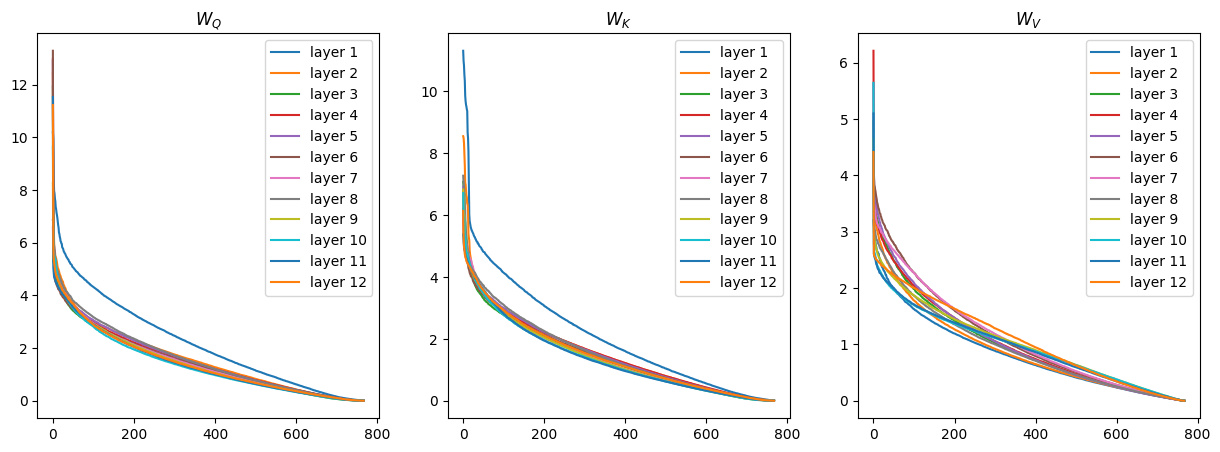

In [17]:
types = [r"$W_Q$", r"$W_K$", r"$W_V$"]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, type in enumerate(types):
    ax = axes[i]
    for j, s_vals in enumerate(s_list[i]):
        ax.plot(list(range(len(s_vals))), s_vals, label=f"layer {j+1}")
    ax.legend()
    ax.set_title(type)

In [4]:
b_list = []
for i in range(model.encoder.config.num_hidden_layers):
    Wq = model.encoder.encoder.layer[i].attention.self.query.weight.numpy()
    Wk = model.encoder.encoder.layer[i].attention.self.key.weight.numpy()
    B = Wq @ Wk.T
    b_list.append(scp.linalg.svdvals(B))

Text(0.5, 1.0, '$B = W_Q W_K^\\top$')

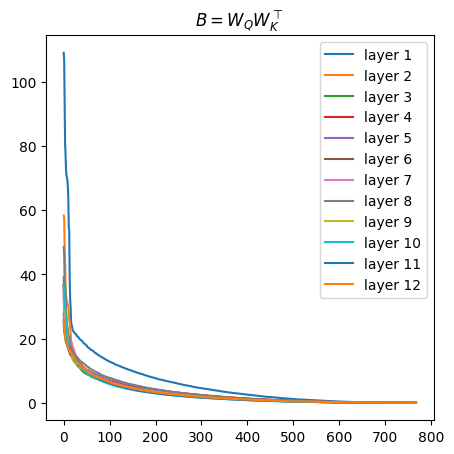

In [5]:
fig, ax = plt.subplots(figsize=(5, 5))
for j, s_vals in enumerate(b_list):
        ax.plot(list(range(len(s_vals))), s_vals, label=f"layer {j+1}")
ax.legend()
ax.set_title(r"$B = W_Q W_K^\top$")

In [9]:
B = Wq @ Wk.T

In [13]:
U, S, Vt = scp.linalg.svd(B, full_matrices=False)

In [13]:
r_list = np.arange(1, len(S), 1)
approx_err = []
for r in r_list:
    Sr = np.copy(S)
    Sr[r:] = 0
    Bh = U @ np.diag(Sr) @ Vt
    approx_err.append(np.linalg.norm(B - Bh, ord='fro'))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


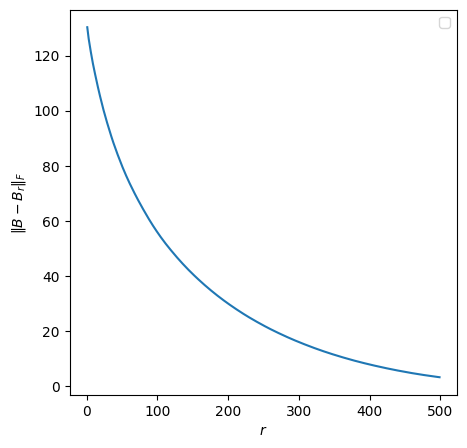

In [17]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(r_list, approx_err)
ax.legend()
ax.set_ylabel(r"$\| B - B_r \|_F$")
ax.set_xlabel(r"$r$")
plt.show()

In [22]:
from lora.models.roberta import get_model   
from omegaconf import OmegaConf
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt
from lora.compress.gregodec import GreGoDec

import torch
import torch.nn as nn
import math

In [2]:
args = OmegaConf.load('/cis/home/adesilva/ashwin/research/cs-project/config.yaml')
model = get_model(args)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [61]:
query = model.encoder.encoder.layer[-1].attention.self.query
key = model.encoder.encoder.layer[-1].attention.self.key

Wq = torch.vstack([query.weight.transpose(0, 1), query.bias]).numpy()
Wk = torch.vstack([key.weight.transpose(0, 1), key.bias]).numpy()
B = Wq @ Wk.T

In [62]:
U, V, S, error = GreGoDec(
    D = B,
    rank = 100,
    tau = 0.5,
    tol = 1e-2, 
    power = 10,
    k = 5
).fit()

In [67]:
np.random.seed(1996)
X = np.random.randn(128, B.shape[0])

Y = softmax(X @ B @ X.T)
Yhat = softmax(X @ (U @ V + S) @ X.T)

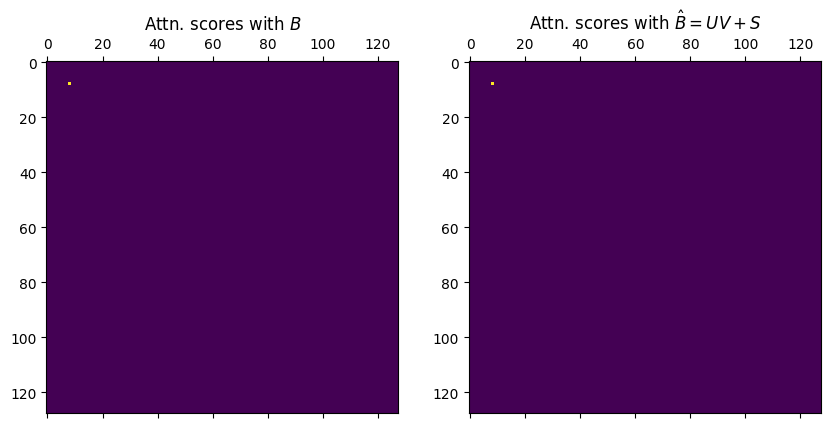

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = axes[0]
ax.matshow(Y)
ax.set_title(r"Attn. scores with $B$")

ax = axes[1]
ax.matshow(Yhat)
ax.set_title(r"Attn. scores with $\hat B = UV + S$")
plt.show()

In [ ]:
# inject lora matrices to Wq and Wv

for i in range(model.config.num_hidden_layers):
    old = model.encoder.layer[i].attention.self.query
    model.encoder.layer[i].attention.self.query = Linear(768, 768, r=args.lora_r, lora_alpha=args.lora_alpha)
    model.encoder.layer[i].attention.self.query.weight = old.weight
    model.encoder.layer[i].attention.self.query.bias = old.bias

    old = model.encoder.layer[i].attention.self.value
    model.encoder.layer[i].attention.self.value = Linear(768, 768, r=args.lora_r, lora_alpha=args.lora_alpha)
    model.encoder.layer[i].attention.self.value.weight = old.weight
    model.encoder.layer[i].attention.self.value.bias = old.bias

In [18]:
old = model.encoder.encoder.layer[0].attention.self.query

In [23]:
x = torch.randn(100, 768)

In [51]:
q = old(x)
qh = torch.matmul(x, old.weight.transpose(0, 1)) + old.bias

x_ = torch.hstack([x, torch.ones((x.shape[0], 1))])
W_ = torch.vstack([old.weight.transpose(0, 1), old.bias])
qhh = torch.matmul(x_, W_)


In [45]:
q

tensor([[ 3.4695e+00,  6.3474e-01,  6.8642e-01,  ..., -3.3558e+00,
          3.6710e+00, -1.6217e-03],
        [-7.0462e+00, -2.5944e+00, -1.2039e+00,  ...,  1.8456e+00,
         -1.3003e+00,  1.8121e+00],
        [ 2.1126e+00,  3.0353e+00, -1.6481e+00,  ..., -3.9707e+00,
          2.7503e+00,  2.1176e+00],
        ...,
        [-8.1714e-01, -1.9987e+00,  1.7981e+00,  ..., -4.9167e+00,
          7.5774e-01, -1.1348e+00],
        [-3.9318e+00,  5.1912e-01, -4.3103e+00,  ...,  5.4742e-01,
         -9.0551e-01,  2.4708e+00],
        [-2.3396e+00, -1.6359e+00, -1.6191e+00,  ...,  9.2994e-01,
          1.9763e+00, -7.3715e+00]], grad_fn=<AddBackward0>)

In [53]:
qhh

tensor([[ 3.4695e+00,  6.3474e-01,  6.8642e-01,  ..., -3.3558e+00,
          3.6710e+00, -1.6226e-03],
        [-7.0462e+00, -2.5944e+00, -1.2039e+00,  ...,  1.8456e+00,
         -1.3003e+00,  1.8121e+00],
        [ 2.1126e+00,  3.0353e+00, -1.6481e+00,  ..., -3.9707e+00,
          2.7503e+00,  2.1176e+00],
        ...,
        [-8.1714e-01, -1.9987e+00,  1.7981e+00,  ..., -4.9167e+00,
          7.5774e-01, -1.1348e+00],
        [-3.9318e+00,  5.1912e-01, -4.3103e+00,  ...,  5.4742e-01,
         -9.0551e-01,  2.4708e+00],
        [-2.3396e+00, -1.6359e+00, -1.6191e+00,  ...,  9.2993e-01,
          1.9763e+00, -7.3715e+00]])

In [28]:
torch.norm(q - qh, p='fro')

tensor(1113.3492, grad_fn=<LinalgVectorNormBackward0>)

In [117]:
class RobertaSelfAttention(nn.Module):
    def __init__(self, config, manual):
        super().__init__()
        
        self.manual = manual

        if config.hidden_size % config.num_attention_heads != 0 and not hasattr(config, "embedding_size"):
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (config.hidden_size, config.num_attention_heads)
            )

        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.Wq = torch.vstack([self.query.weight.transpose(0, 1), self.query.bias])
        
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.Wk = torch.vstack([self.key.weight.transpose(0, 1), self.key.bias])

        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)
        self.position_embedding_type = getattr(config, "position_embedding_type", "absolute")
        if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
            self.max_position_embeddings = config.max_position_embeddings
            self.distance_embedding = nn.Embedding(2 * config.max_position_embeddings - 1, self.attention_head_size)

        self.is_decoder = config.is_decoder

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_value=None,
        output_attentions=False,
    ):
        mixed_query_layer = self.query(hidden_states)

        # If this is instantiated as a cross-attention module, the keys
        # and values come from an encoder; the attention mask needs to be
        # such that the encoder's padding tokens are not attended to.
        is_cross_attention = encoder_hidden_states is not None

        if is_cross_attention and past_key_value is not None:
            # reuse k,v, cross_attentions
            key_layer = past_key_value[0]
            value_layer = past_key_value[1]
            attention_mask = encoder_attention_mask
        elif is_cross_attention:
            key_layer = self.transpose_for_scores(self.key(encoder_hidden_states))
            value_layer = self.transpose_for_scores(self.value(encoder_hidden_states))
            attention_mask = encoder_attention_mask
        elif past_key_value is not None:
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))
            key_layer = torch.cat([past_key_value[0], key_layer], dim=2)
            value_layer = torch.cat([past_key_value[1], value_layer], dim=2)
        else:
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))

        query_layer = self.transpose_for_scores(mixed_query_layer)

        if self.is_decoder:
            # if cross_attention save Tuple(torch.Tensor, torch.Tensor) of all cross attention key/value_states.
            # Further calls to cross_attention layer can then reuse all cross-attention
            # key/value_states (first "if" case)
            # if uni-directional self-attention (decoder) save Tuple(torch.Tensor, torch.Tensor) of
            # all previous decoder key/value_states. Further calls to uni-directional self-attention
            # can concat previous decoder key/value_states to current projected key/value_states (third "elif" case)
            # if encoder bi-directional self-attention `past_key_value` is always `None`
            past_key_value = (key_layer, value_layer)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        if self.manual:
            B = torch.matmul(self.Wq, self.Wk.transpose(0, 1))
            X = torch.cat([hidden_states, torch.ones(hidden_states.size()[:-1] + (1,))], dim=-1)
            attention_scores = torch.matmul(
                torch.matmul(X, B),
                X.permute(0, 2, 1)
            )
        else:
            attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))

        if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
            seq_length = hidden_states.size()[1]
            position_ids_l = torch.arange(seq_length, dtype=torch.long, device=hidden_states.device).view(-1, 1)
            position_ids_r = torch.arange(seq_length, dtype=torch.long, device=hidden_states.device).view(1, -1)
            distance = position_ids_l - position_ids_r
            positional_embedding = self.distance_embedding(distance + self.max_position_embeddings - 1)
            positional_embedding = positional_embedding.to(dtype=query_layer.dtype)  # fp16 compatibility

            if self.position_embedding_type == "relative_key":
                relative_position_scores = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
                attention_scores = attention_scores + relative_position_scores
            elif self.position_embedding_type == "relative_key_query":
                relative_position_scores_query = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
                relative_position_scores_key = torch.einsum("bhrd,lrd->bhlr", key_layer, positional_embedding)
                attention_scores = attention_scores + relative_position_scores_query + relative_position_scores_key

        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        if attention_mask is not None:
            # Apply the attention mask is (precomputed for all layers in RobertaModel forward() function)
            attention_scores = attention_scores + attention_mask

        # Normalize the attention scores to probabilities.
        attention_probs = nn.Softmax(dim=-1)(attention_scores)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)

        # Mask heads if we want to
        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        context_layer = torch.matmul(attention_probs, value_layer)

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)

        outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)

        if self.is_decoder:
            outputs = outputs + (past_key_value,)
        return outputs

In [116]:
torch.manual_seed(1996)
x = torch.randn((1, 514, 768))

In [118]:
attn1 = RobertaSelfAttention(model.encoder.encoder.config, manual=False)
attn2 = RobertaSelfAttention(model.encoder.encoder.config, manual=True)

In [119]:
y1 = attn1(x)
y1

(tensor([[[-0.0317, -0.0020,  0.0262,  ...,  0.0111, -0.0640,  0.0274],
          [-0.0435,  0.0107,  0.0095,  ...,  0.0175, -0.0855,  0.0200],
          [-0.0489, -0.0115,  0.0375,  ...,  0.0260, -0.0648,  0.0101],
          ...,
          [-0.0333, -0.0228,  0.0099,  ..., -0.0064, -0.0565,  0.0161],
          [-0.0390, -0.0242,  0.0237,  ..., -0.0092, -0.0485,  0.0370],
          [-0.0388, -0.0150, -0.0186,  ..., -0.0046, -0.0581,  0.0302]]],
        grad_fn=<ViewBackward0>),)

In [120]:
y2 = attn2(x)
y2

(tensor([[[-0.0044, -0.0641,  0.0444,  ..., -0.0650,  0.0024,  0.0301],
          [ 0.0008, -0.0884,  0.0291,  ...,  0.0216,  0.0780, -0.0160],
          [ 0.0077,  0.0489, -0.0698,  ..., -0.0180,  0.0778,  0.0162],
          ...,
          [-0.0106,  0.0214, -0.0058,  ..., -0.1214, -0.0998, -0.0349],
          [-0.0185, -0.0532, -0.0099,  ...,  0.0096, -0.0229,  0.0045],
          [ 0.0498, -0.1087, -0.0304,  ...,  0.0089, -0.0102,  0.0635]]],
        grad_fn=<ViewBackward0>),)

In [132]:
K = attn1.transpose_for_scores(attn1.key(x))
Q = attn1.transpose_for_scores(attn1.query(x))
V = attn1.transpose_for_scores(attn1.value(x))

In [129]:
attention_scores = torch.matmul(Q, K.transpose(-1, -2))
attention_probs = nn.Softmax(dim=-1)(attention_scores)

In [131]:
attention_probs.shape

torch.Size([1, 12, 514, 514])

In [135]:
context_layer = torch.matmul(attention_probs, V)
context_layer = context_layer.permute(0, 2, 1, 3).contiguous()

In [136]:
context_layer.shape

torch.Size([1, 514, 12, 64])